# Modeling TCLab

Alex Dowling, University of Notre Dame

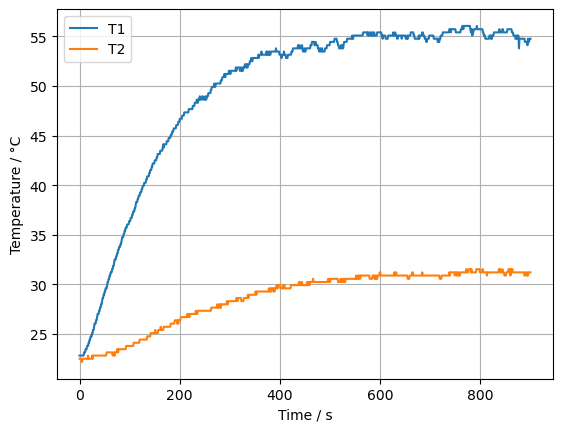

In [1]:
# -----------------------------------------------------------------------
# Local version of 'from FoKL import FoKLRoutines':
import os
import sys
dir = os.path.abspath(os.path.dirname(os.path.realpath('__file__')))  # directory of script
sys.path.append(dir)
sys.path.append(os.path.join(dir, '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
# -----------------------------------------------------------------------
import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

# filename = 'tclab_sine_test.csv'
filename = 'tclab_step_test.csv'

data = pd.read_csv(filename)
data.plot(x='Time', y=['T1', 'T2'], grid=True, xlabel='Time / s', ylabel='Temperature / °C')
plt.show()

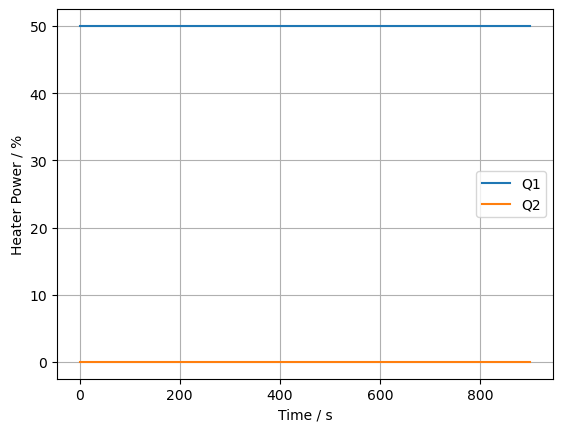

In [2]:
data.plot(x='Time', y=['Q1', 'Q2'], grid=True, xlabel='Time / s', ylabel='Heater Power / %')
plt.show()

## Linear System Model

In [3]:
# define the time vector
t = data['Time'].values
print("length of time vector: ", len(t))

# calculate Tamb
Tamb = data['T1'].values[0]

u_function = lambda t: np.interp(t, data['Time'].values, data['Q1'].values)

def single_heater_model(t, T, u_function, theta):    
    dTdt = theta[0]*(Tamb-T) + theta[1]*u_function(t)
    return dTdt

length of time vector:  901


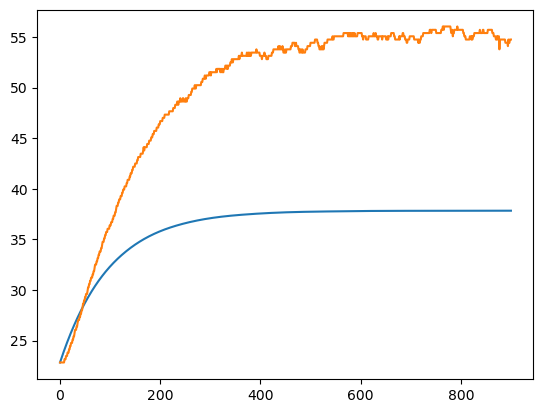

In [4]:
from scipy.integrate import solve_ivp


theta0 = [0.01, 0.003]
sln = solve_ivp(single_heater_model, t_span=(t[0], t[-1]), y0=[Tamb], t_eval=t, args=(u_function, theta0))

plt.plot(t, sln.y[0], label='Model')
plt.plot(t, data['T1'], label='Data')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.5425e+04                                    5.88e+07    
       1              3         2.8459e+03      9.26e+04       2.61e-03       4.70e+06    
       2              4         1.2814e+03      1.56e+03       5.22e-03       3.14e+06    
       3              5         3.2020e+02      9.61e+02       1.48e-03       2.60e+05    
       4              6         3.1441e+02      5.78e+00       1.53e-04       1.02e+04    
       5              7         3.1439e+02      2.27e-02       1.00e-05       4.22e+02    
       6              8         3.1439e+02      1.39e-04       8.02e-07       3.36e+01    
       7              9         3.1439e+02      8.33e-07       6.30e-08       2.64e+00    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 9.5425e+04, final cost 3.1439e+02, first-order optimality 2.64e+00.
[0.00594762 0.00393785]


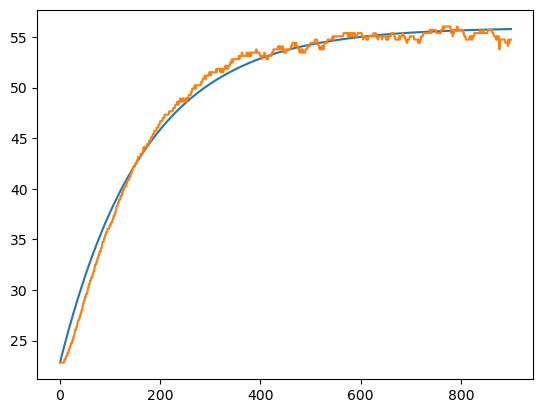

In [5]:
def residual(theta):
    sln = solve_ivp(single_heater_model, t_span=(t[0], t[-1]), y0=[Tamb], t_eval=t, args=(u_function, theta))
    return sln.y[0] - data['T1'].values

from scipy.optimize import least_squares
regress_results = least_squares(residual, theta0, verbose=2)

print(regress_results.x)

sln = solve_ivp(single_heater_model, t_span=(t[0], t[-1]), y0=[Tamb], t_eval=t, args=(u_function, regress_results.x))

plt.plot(t, sln.y[0], label='Model')
plt.plot(t, data['T1'], label='Data')

## Two State Model

<>:179: SyntaxWarning: invalid escape sequence '\c'
<>:179: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_54217/3530982681.py:179: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("$T_1$ residuals [$^\circ{}$C]",fontsize=fs,fontweight = 'bold')


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8146e+02                                    1.05e+09    
       1              2         2.4374e+02      3.77e+01       4.56e-02       2.21e+07    
       2              3         1.9183e+02      5.19e+01       1.29e-03       1.60e+08    
       3             10         1.9161e+02      2.17e-01       5.94e-06       7.88e+04    
       4             11         1.9079e+02      8.30e-01       4.20e-07       3.37e+07    
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 2.8146e+02, final cost 1.9079e+02, first-order optimality 3.37e+07.
CpH =  7.006 J/degC
CpS = 0.01 J/degC
Ua =  0.051 W/degC
Ub =  0.001 W/degC


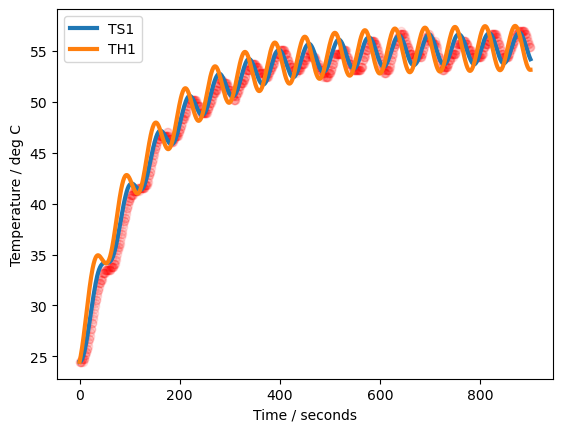

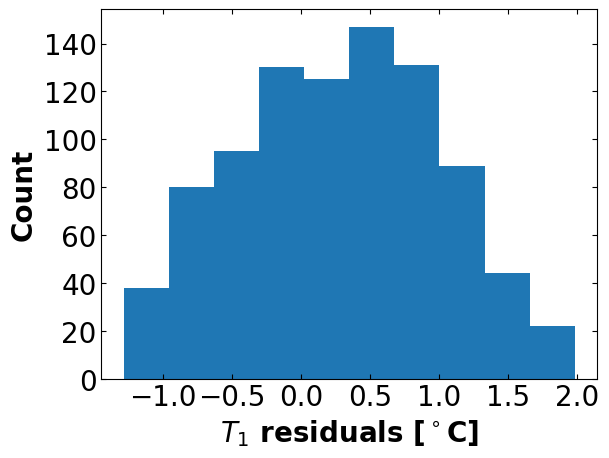

Estimated standard deviation of residuals: 0.771 deg C

Covariance of p = [Ua, Ub, inv_CpH, inv_CpS]
[[ 2.90801047e-09 -3.94220313e-13 -3.58788073e-13 -2.71788410e-07]
 [-3.94220313e-13  6.00932167e-16 -3.15741735e-16  3.67862437e-11]
 [-3.58788073e-13 -3.15741735e-16  3.44082180e-15  3.25470405e-11]
 [-2.71788410e-07  3.67862437e-11  3.25470405e-11  2.54046818e-05]]

Correlation matrix
[[ 1.         -0.29821418 -0.11342504 -0.9999449 ]
 [-0.29821418  1.         -0.21957767  0.29772537]
 [-0.11342504 -0.21957767  1.          0.11008383]
 [-0.9999449   0.29772537  0.11008383  1.        ]]


In [6]:
filename = 'tclab_sine_test.csv'

data2 = pd.read_csv(filename)
T_amb = data2["T1"].values[0]

# known parameters
# T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units

# adjustable parameters
CpH = 7                # joules/deg C
CpS = 0.01              # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.001              # watts/deg C

# initial conditions
TH1 = T_amb
TS1 = T_amb
IC = [TH1, TS1]

# input values
U1 = lambda t: 50                # steady state value of u1 (percent)

# extract data from experiment
t_expt = np.linspace(0, 600, 601)

def tclab_ode(theta, U1, T_amb, t_expt, return_data_frame=False):
    ''' ODE system for TCLab

    Arguments:
        theta: list fitted parameters CpH, CpS, Ua, Ub
        U1: function that returns the value of U1 at time t
        T_amb: ambient temperature
        t_expt: time values for the experiment

    '''

    # unpack the adjustable parameters
    Ua, Ub, inv_CpH, inv_CpS = theta

    # right hand side of the ODEs
    def deriv(t, y):

        TH1, TS1 = y
        dTH1 = (-Ua*(TH1 - T_amb) + Ub*(TS1 - TH1) + alpha*P1*U1(t))*inv_CpH
        dTS1 = Ub*(TH1 - TS1)*inv_CpS
        return [dTH1, dTS1]

    # define the initial conditions
    IC = [T_amb, T_amb]

    # numerically integrate the ODEs
    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], IC, t_eval=t_expt) 

    if return_data_frame:
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred = pred.set_index("Time")
        
        # report the model temperatures
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        pred["Q1"] = U1(t_expt)
            
        return pred
    else:
        return soln.y[1]
    
pred = tclab_ode(theta=[Ua, Ub, 1/CpH, 1/CpS], 
                 U1=U1,
                 T_amb=T_amb,
                 t_expt=t_expt,
                 return_data_frame=True)
pred

from scipy.optimize import least_squares

def covariance_to_correlation(cov):
    ''' Convert covariance matrix into correlation matrix

    Argument:
        cov: covariance matrix

    Returns:
        cor: correlation matrix

    '''

    # Copy matrix
    cor = cov.copy()

    # Get number of rows
    n = cor.shape[0]

    # Loop over rows
    for r in range(n):
        # Loop over columns
        for c in range(n):
            # Scale element
            cor[r,c] = cor[r,c] / np.sqrt(cov[r,r]*cov[c,c])

    return cor

def perform_regression(data, theta_initial=[Ua, Ub, 1/CpH, 1/CpS]):
    ''' Regress the data to find the parameters Ua, Ub, inv_CpH, inv_CpS

    Arguments:
        data: pandas DataFrame with columns "Time", "Q1", "T1", "T2"
        theta_initial: initial guess for the parameters
    '''

    # Interpolate the constrol signal
    U1 = lambda t: np.interp(t, data["Time"], data["Q1"])

    # Calculate the initial conditions
    T_amb = data.T1.values[0]

    # Assemble y data
    y_data = data["T1"].values

    # Define residual function
    def residuals(p):
        pred = tclab_ode(p, 
                            U1,
                            T_amb, 
                            data["Time"].to_numpy(),
                            return_data_frame=False)
        return pred - y_data
    
    # Set bounds for Ua, Ub, inv_CpH, inv_CpS
    # These are based on physical intuition
    bnds = ([1E-5, 1E-5, 1E-2, 1E-2], [2.0, 2.0, 100, 100])
    
    # Perform least squares nonlinear regression
    nl_results = least_squares(residuals, 
                               theta_initial, 
                               bounds=bnds, 
                               method='trf', 
                               verbose=2, 
                               loss="arctan")
    theta_hat = nl_results.x

    # extract and print values
    Ua, Ub, inv_CpH, inv_CpS = nl_results.x
    CpH = 1/inv_CpH
    CpS = 1/inv_CpS

    print('CpH = ', round(CpH,3), "J/degC")
    print('CpS =', round(CpS,3), "J/degC")
    print('Ua = ', round(Ua,3), "W/degC")
    print('Ub = ', round(Ub, 3), "W/degC")

    # plot the results
    pred = tclab_ode([Ua, Ub, inv_CpH, inv_CpS],
                        U1,
                        T_amb,
                        data["Time"].to_numpy(),
                        return_data_frame=True)
    ax = data["T1"].plot(marker='o',color='red', alpha=0.1)
    pred[["TS1", "TH1"]].plot(ax=ax, linewidth=3, xlabel="Time / seconds", ylabel="Temperature / deg C")
    plt.show()

    # plot the residuals
    r = residuals(nl_results.x)

    # define font size
    fs = 20

    # plot data
    plt.hist(r)
    plt.xlabel("$T_1$ residuals [$^\circ{}$C]",fontsize=fs,fontweight = 'bold')
    plt.ylabel("Count",fontsize=fs,fontweight = 'bold')

    # define tick size
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.tick_params(direction="in",top=True, right=True)

    # finish plot
    plt.show()

    # Estimate covariance and correlation of fitted parameters

    #Estimate covariance of residuals
    var_residuals = r.T@r / (len(r) - len(nl_results.x))
    print("Estimated standard deviation of residuals:",round(np.sqrt(var_residuals),3),"deg C")

    # Estimate covariance of fitted parameters
    cov_p = var_residuals * np.linalg.inv(nl_results.jac.T @ nl_results.jac)


    print("\nCovariance of p = [Ua, Ub, inv_CpH, inv_CpS]")
    print(cov_p)

    print("\nCorrelation matrix")
    print(covariance_to_correlation(cov_p))

    return theta_hat, r

    
theta_hat, resid = perform_regression(data=data2)

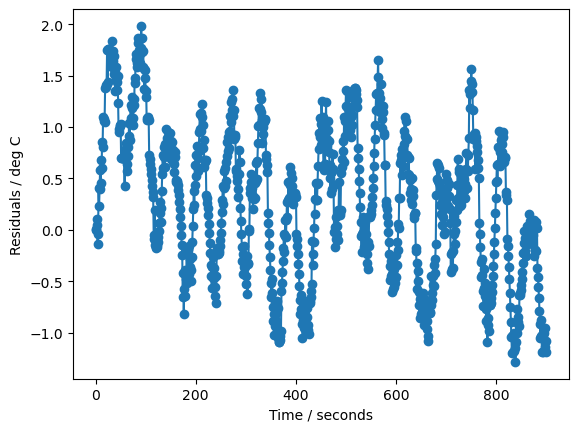

In [7]:
plt.plot(data2["Time"], resid, marker='o')
plt.xlabel("Time / seconds")
plt.ylabel("Residuals / deg C")
plt.show()

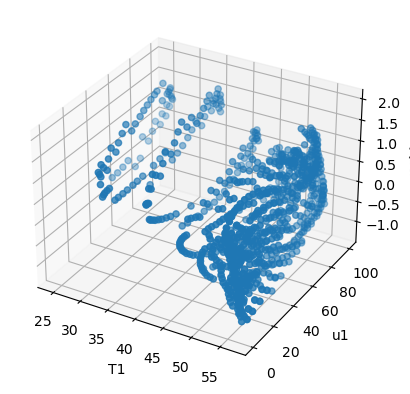

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data2['T1'], data2['Q1'], resid)
ax.set_xlabel('T1')
ax.set_ylabel('u1')
ax.set_zlabel('resid')
plt.show()

## GP Discrepency Model

We want to train the following mathematical model:

$$
\frac{dT_1}{dt} = f(T_1, Q_1)
$$

where $f(\cdot, \cdot)$ is the GP.

length of time vector:  901
length of derivative vector:  901
length of u1 vector:  901


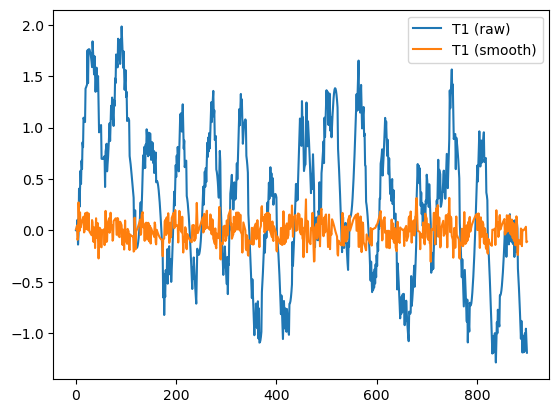

In [9]:
# TODO: look into smoothing the data, or fit smoothing GP to the data
# good chance the derivative is really noisy
# look for "smooth_diff"

residuals = pd.Series(resid)

# apply rolling mean to smooth the data
window = 5
resid_smooth = residuals.rolling(window=window).mean()

# copy the first window values to the beginning of the smoothed data
resid_smooth[0:window] = resid[0:window]

# define the time vector
t = data2['Time'].values
print("length of time vector: ", len(t))

# calculate the derivative of the smoothed data
dresiddt = np.gradient(resid, t)
print("length of derivative vector: ", len(dresiddt))

# calculate Tamb
Tamb = dresiddt[0]

# define the vector for temperature
T1 = data2['T1'].values

# print("length of T1_smooth vector: ", len(dresiddt))

u1 = data2['Q1'].values
print("length of u1 vector: ", len(u1))


plt.plot(t, resid, label='T1 (raw)')
plt.plot(t, dresiddt, label='T1 (smooth)')
plt.legend()
plt.show()


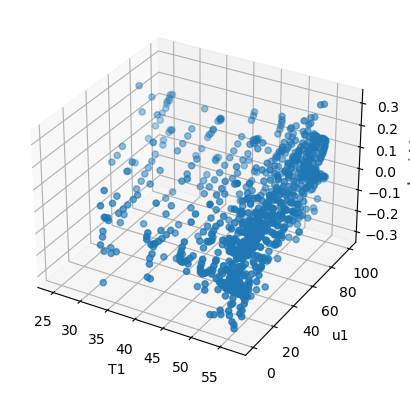

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(T1, u1, dresiddt)
ax.set_xlabel('T1')
ax.set_ylabel('u1')
ax.set_zlabel('dresiddt')
plt.show()

## Model 1: Predict Residual

In [11]:
Xtrain = np.array([T1 - Tamb, u1]).T

try:
    f = FoKLRoutines.load('v2_attempt1.fokl')
except Exception as exception:
    f = FoKLRoutines.FoKL(kernel=1)
    print("\nTraining FoKL model...")
    _ = f.fit(Xtrain, resid, clean=True)
    print("Done!")
    f.save('v2_attempt1.fokl')


Training FoKL model...
[1, 132.66270371348324]
[2, 134.6062822331698]
[2, 131.77589181709772]
[3, 131.77589181709772]
[3, 127.81494571844334]
[4, 127.81494571844334]
[4, 125.5401082172218]
[4, 91.4248977395182]
[5, 92.20415622708778]
[5, 92.20415622708778]
[5, 92.35861062911661]
Done!


'attempt1.fokl'

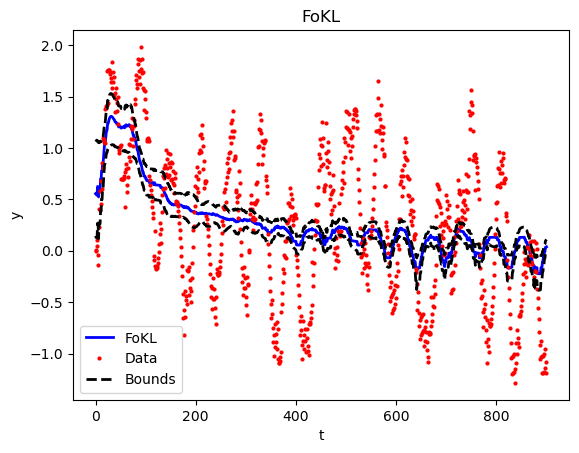

In [12]:
# Plot to visualize dataset and model:
_ = f.coverage3(plot=True, xlabel='t', xaxis=t, ylabel='y')

In [13]:
resid_pred = f.evaluate()  # by default, uses noramlized Xtrain (i.e., f.inputs), betas, and mtx; all were saved as attributes during fit

In [14]:
T_values = np.linspace(20, 60, 11) - T_amb
u_values = np.linspace(0, 100, 11)

xv, yv = np.meshgrid(T_values, u_values, indexing='ij')
zv = np.zeros(xv.shape)
for i in range(len(T_values)):
    for j in range(len(u_values)):
        zv[i,j] = f.evaluate(np.array([xv[i,j], yv[i,j]]), clean=True)[0]  # 'clean=True' to normalize true scale inputs prior to evaluate

Text(0.5, 0, 'residuals')

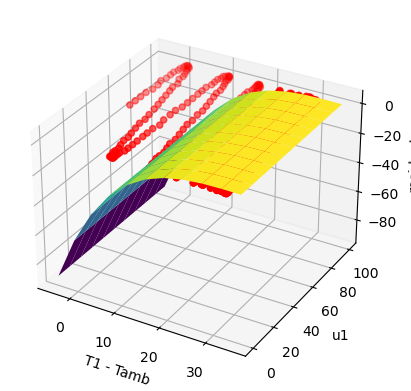

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xv, yv, zv, cmap='viridis')
ax.scatter(T1 - T_amb, u1, resid, color='red')
ax.set_xlabel('T1 - Tamb')
ax.set_ylabel('u1')
ax.set_zlabel('residuals')

This appears to be a poor quality of fit. I an not confident I am using the evaluate function correctly. -Alex

<br>

[UPDATE 2024/06/03]
- evaluate should be ok now, but not sure if plot is as expected. -Jacob

In [16]:
xpred = np.array([55 - T_amb, 50.]).T
print(f.evaluate(xpred, clean=True))

[1.37071126 0.26813261]


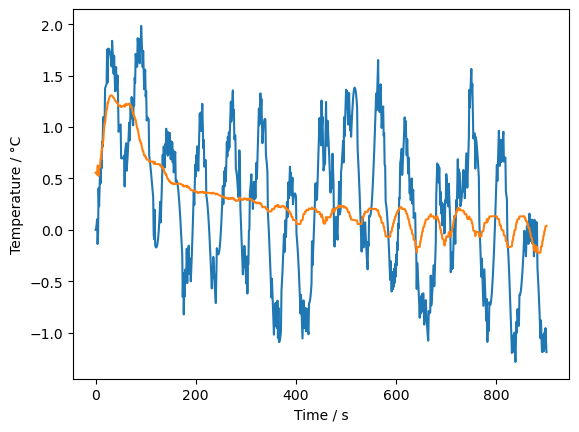

In [17]:
plt.plot(t, resid, label='residual (raw)')
plt.plot(t, resid_pred, label='residual (FoKL)')
plt.xlabel('Time / s')
plt.ylabel('Temperature / °C')
plt.show()

In [20]:
'''
dt = np.gradient(t)

# This is a very simple integration of the derivative to get the prediction
T1_pred = np.cumsum(dT1dt_pred*dt)

plt.plot(t, T1_smooth, label='T1 data', marker='o')
plt.plot(t, T1_pred + Tamb, label='T1 prediction', linestyle='-')
plt.legend()
plt.show()
'''

"\ndt = np.gradient(t)\n\n# This is a very simple integration of the derivative to get the prediction\nT1_pred = np.cumsum(dT1dt_pred*dt)\n\nplt.plot(t, T1_smooth, label='T1 data', marker='o')\nplt.plot(t, T1_pred + Tamb, label='T1 prediction', linestyle='-')\nplt.legend()\nplt.show()\n"

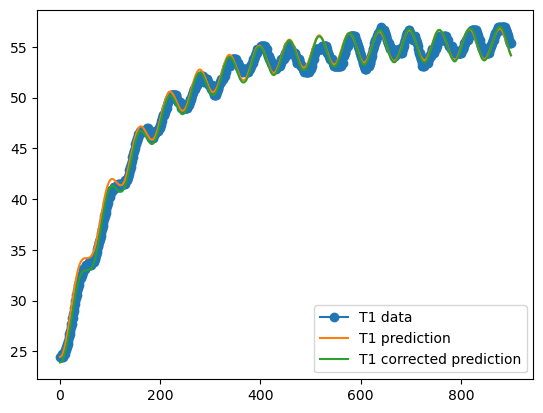

In [21]:
T1_pred = T1 + resid

plt.plot(t, T1, label='T1 data', marker='o')
plt.plot(t, T1_pred , label='T1 prediction', linestyle='-')
plt.plot(t, T1_pred - resid_pred, label='T1 corrected prediction', linestyle='-')
plt.legend()

## Model 2: Predict Derivative of Residuals

In [22]:
try:
    f2 = FoKLRoutines.load('v2_attempt2.fokl')
except Exception as exception:
    f2 = FoKLRoutines.FoKL(kernel=1)
    print("\nTraining FoKL model...")
    _ = f2.fit(Xtrain, dresiddt, clean=True)
    print("Done!")
    f2.save('v2_attempt2.fokl')


Training FoKL model...
[1, -3370.658503030393]
[2, -3370.658503030393]
[2, -3365.735843839127]
[3, -3359.5186330927545]
Done!


'attempt2.fokl'

In [24]:
xpred = np.zeros(2)
xpred[0] = 55 - T_amb
xpred[1] = 25

_ = f2.evaluate(xpred, clean=True, SingleInstance=True)  # set 'SingleInstance=True' to handle exception caused by auto-formatting

In [26]:
u1_func = lambda t: np.interp(t, data2['Time'].values, data2['Q1'].values)

def tclab_ode2(theta, U1 = u1_func, T_amb=T_amb, t_expt=data2["Time"].values, return_data_frame=False):
    ''' ODE system for TCLab

    Arguments:
        theta: list fitted parameters CpH, CpS, Ua, Ub
        U1: function that returns the value of U1 at time t
        T_amb: ambient temperature
        t_expt: time values for the experiment

    '''

    # unpack the adjustable parameters
    Ua, Ub, inv_CpH, inv_CpS = theta

    # right hand side of the ODEs
    def deriv(t, y):
        

        TH1, TS1 = y


        r = f2.evaluate(np.array([TS1 - T_amb, U1(t)]), clean=True, SingleInstance=True)[0]
        # print("r = ",r)

        dTH1 = (-Ua*(TH1 - T_amb) + Ub*(TS1 - TH1) + alpha*P1*U1(t))*inv_CpH
        dTS1 = Ub*(TH1 - TS1)*inv_CpS + r
        return [dTH1, dTS1]

    # define the initial conditions
    IC = [T_amb, T_amb]

    # numerically integrate the ODEs
    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], IC, t_eval=t_expt) 

    if return_data_frame:
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred = pred.set_index("Time")
        
        # report the model temperatures
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        pred["Q1"] = U1(t_expt)
            
        return pred
    else:
        return soln.y[1]
    
pred = tclab_ode2(theta=theta_hat)

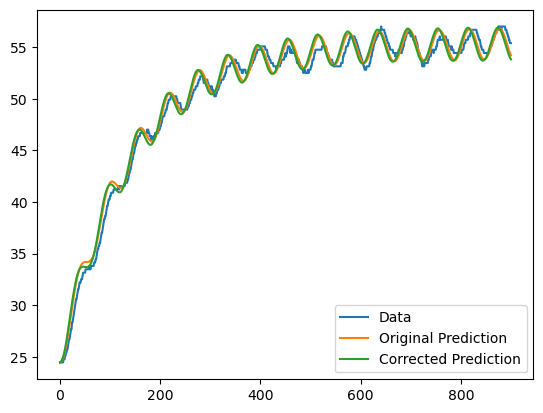

In [27]:
plt.plot(t, data2['T1'], label='Data')
plt.plot(t, T1_pred, label='Original Prediction')
plt.plot(t, pred, label='Corrected Prediction')
plt.legend()